In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                         GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# converting into dataframe

In [2]:
root='/kaggle/input/brain-tumor/'
data={}
for class_ in os.listdir(root):
    for image in os.listdir(root+class_):
        data[root+class_+'/'+image]=class_

In [3]:
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data

,path,class_
801,/kaggle/input/brain-tumor/2/782.png,2
25,/kaggle/input/brain-tumor/2/1948.png,2
340,/kaggle/input/brain-tumor/2/1925.png,2
1071,/kaggle/input/brain-tumor/2/461.png,2
238,/kaggle/input/brain-tumor/2/796.png,2
...,...,...
2847,/kaggle/input/brain-tumor/1/3037.png,1
1019,/kaggle/input/brain-tumor/2/1310.png,2
2653,/kaggle/input/brain-tumor/1/2811.png,1
547,/kaggle/input/brain-tumor/2/1311.png,2


In [4]:
data['class_']=data['class_'].map({ '1': 'meningioma', '2': 'glioma', '3':'pituitary', })
data

,path,class_
801,/kaggle/input/brain-tumor/2/782.png,glioma
25,/kaggle/input/brain-tumor/2/1948.png,glioma
340,/kaggle/input/brain-tumor/2/1925.png,glioma
1071,/kaggle/input/brain-tumor/2/461.png,glioma
238,/kaggle/input/brain-tumor/2/796.png,glioma
...,...,...
2847,/kaggle/input/brain-tumor/1/3037.png,meningioma
1019,/kaggle/input/brain-tumor/2/1310.png,glioma
2653,/kaggle/input/brain-tumor/1/2811.png,meningioma
547,/kaggle/input/brain-tumor/2/1311.png,glioma


# data visualization

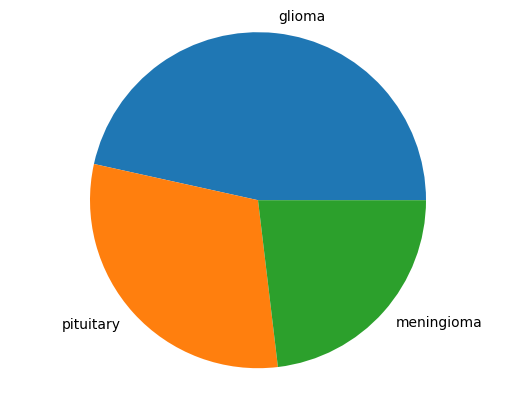

In [5]:
_,_,autotexts=plt.pie(data["class_"].value_counts(), labels=data['class_'].unique() , autopct='')
plt.axis('equal')
# plt.title('data distribution')
for autotext in autotexts:
    autotext.set_visible(False)

In [6]:
# images=[]
# labels=[]
# for class_ in data['class_'].unique():
#     image=(cv2.imread(data[data['class_']==class_].iloc[0]["path"]))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     images.append(image)
#     labels.append(data[data['class_']==class_].iloc[0]["class_"])
    

In [7]:
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4))
# for i, ax in enumerate(axes.flat):
#     img = images[i]
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(labels[i])


# plt.tight_layout()

# plt.show()

# data deviding ratio : 70:10:20 for train:validatino:test

In [8]:
n=len(data)
train_last=int(0.7*n)
valid_last=int(0.8*n)
train=data[:train_last]
validation=data[train_last:valid_last]
test=data[valid_last:]
test
test.to_csv('test.csv',index=False)

# defining hyper-parameters

In [9]:
batch_size=16
size=224 #image size
epoch=20

# Image Preprocessing

In [10]:
def roi_select(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,thresholded = cv2.threshold(grayscale, 0, 255, cv2.THRESH_OTSU)
    bbox = cv2.boundingRect(thresholded)
    x, y, w, h = bbox
    foreground = img[y:y+h, x:x+w]
    return foreground
def apply_adaptive_histogram_equalization(image, clip_limit=2.0, grid_size=(8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    ahe_image = clahe.apply(gray_image)
    ahe_image_rgb = cv2.cvtColor(ahe_image, cv2.COLOR_GRAY2RGB)
    return ahe_image_rgb

def preprocess(img):
    img = img.astype("uint8")
    img=apply_adaptive_histogram_equalization(roi_select(img))/255.0
    return tf.image.resize(img,(size,size)).numpy()

# defining generators

In [11]:
train_datagen = ImageDataGenerator(
#     rescale=1.0 / 255,
    preprocessing_function=preprocess,
        rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

Found 2144 validated image filenames belonging to 3 classes.


In [12]:
validation_datagen = ImageDataGenerator(
#     rescale=1.0 / 255,
    preprocessing_function=preprocess,
    fill_mode="nearest",
)
validation_images = validation_datagen.flow_from_dataframe(
    dataframe=validation,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

Found 307 validated image filenames belonging to 3 classes.


In [13]:
test_datagen = ImageDataGenerator(
#     rescale=1.0 / 255,
    preprocessing_function=preprocess,
)
test_images = validation_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

Found 613 validated image filenames belonging to 3 classes.


In [14]:

def non_local_block(input_layer):
    # Calculate the dimensionality of the input features
    dim_c = input_layer.shape[-1]
    
    # Calculate the self-attention maps
    theta = Conv2D(filters=dim_c // 2, kernel_size=(1, 1))(input_layer)
    phi = Conv2D(filters=dim_c // 2, kernel_size=(1, 1))(input_layer)
    g = Conv2D(filters=dim_c // 2, kernel_size=(1, 1))(input_layer)
    
    theta = tf.reshape(theta, shape=(-1, theta.shape[1] * theta.shape[2], theta.shape[3]))
    phi = tf.reshape(phi, shape=(-1, phi.shape[1] * phi.shape[2], phi.shape[3]))
    g = tf.reshape(g, shape=(-1, g.shape[1] * g.shape[2], g.shape[3]))
    
    attention_weights = tf.nn.softmax(tf.matmul(theta, tf.transpose(phi, perm=[0, 2, 1])), axis=-1)
    
    # Compute the attended features
    attended_features = tf.matmul(attention_weights, g)
    attended_features = tf.reshape(attended_features, shape=(-1, input_layer.shape[1], input_layer.shape[2], dim_c // 2))
    
    # Project the attended features
    projection = Conv2D(filters=dim_c, kernel_size=(1, 1))(attended_features)
    
    # Residual connection
    output = Add()([input_layer, projection])
    
    return output

# defining the model

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input


inp=Input(shape=(size, size, 3))

resnet = ResNet152V2(weights='imagenet', include_top=False, input_tensor=Input(shape=(size, size, 3)))
for layer in resnet.layers:
    layer.trainable = False

vgg= VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(size, size, 3)))
for layer in vgg.layers:
    layer.trainable = False  

58889256/58889256 [==============================] - 0s 0us/step


# Modifying VGG16

In [16]:

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, DepthwiseConv2D, GlobalAveragePooling2D, AveragePooling2D, Concatenate, MaxPooling2D


x = inp
blocks=[]
for layer in vgg.layers:
    x = layer(x)
    if layer.name in ['block3_conv3', 'block4_conv3', 'block5_conv3']:
        attention_output = non_local_block(x)
        blocks.append(x)
        x = tf.keras.layers.add([x, attention_output])

st=8
for idx, block in enumerate(blocks):
    filters = block.shape[-1]
    depthwise_conv = DepthwiseConv2D(kernel_size=(3, 3), padding='same')(block)
    depthwise_sep_conv = Conv2D(128, kernel_size=(1, 1), padding='same', activation="selu")(depthwise_conv)
    bn = BatchNormalization()(depthwise_sep_conv)
    pooled_block = MaxPooling2D((st,st))(bn)
    st=st//2
    blocks[idx] = pooled_block
    
blocks.append(x)
x=tf.keras.layers.Concatenate()(blocks)
vgg16=Model(inp,x)

In [17]:
from tensorflow.keras import layers

def dual_attention_block(inputs, reduction_ratio=16):
    # Channel Attention
    channels = inputs.shape[-1]
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(channels // reduction_ratio, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)
    channel_attention = layers.Reshape((1, 1, channels))(x)
    channel_attention = layers.multiply([inputs, channel_attention])


    spatial_attention = layers.Conv2D(1, (1, 1), activation='sigmoid')(inputs)
    spatial_attention = layers.multiply([inputs, spatial_attention])


    attention = layers.add([channel_attention, spatial_attention])
    
    return attention

In [18]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import concatenate
x1= resnet(inp)
x2= vgg16(inp)
x=concatenate([x1, x2])
x=dual_attention_block(x)
xd2=layers.Conv2D(128, (1, 1), activation='relu',name='2Dfeatures')(x)
x1 = tf.keras.layers.GlobalAveragePooling2D()(xd2)
#x2 = tf.keras.layers.GlobalMaxPooling2D()(xd2)
#x=concatenate([x1, x2])
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x1)
x=Dense(16,activation='relu')(x)
x=Dropout(.2)(x)
x=Dense(8,activation='relu')(x)
x=Dropout(.2)(x)
x=Dense(len(train_images.class_indices),activation='softmax')(x)
model=Model(inp,x)

In [19]:
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])
print("trainable parametres: "+ str(trainable_params) + " non trainable parametres: "+ str(non_trainable_params))

trainable parametres: 2829548 non trainable parametres: 73047360


In [20]:
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.experimental.Adamax(),metrics=['accuracy'])

In [21]:
history = model.fit(
    train_images,
    validation_data=validation_images, 
    epochs=50,
)

Epoch 1/50
134/134 [==============================] - 142s 866ms/step - loss: 0.9568 - accuracy: 0.5700 - val_loss: 0.7774 - val_accuracy: 0.7264
Epoch 2/50
134/134 [==============================] - 81s 604ms/step - loss: 0.6791 - accuracy: 0.7048 - val_loss: 0.6037 - val_accuracy: 0.7883
Epoch 3/50
134/134 [==============================] - 80s 596ms/step - loss: 0.6197 - accuracy: 0.7169 - val_loss: 0.4867 - val_accuracy: 0.8371
Epoch 4/50
134/134 [==============================] - 81s 602ms/step - loss: 0.5625 - accuracy: 0.7388 - val_loss: 0.4459 - val_accuracy: 0.8241
Epoch 5/50
134/134 [==============================] - 80s 601ms/step - loss: 0.4980 - accuracy: 0.7799 - val_loss: 0.4506 - val_accuracy: 0.8274
Epoch 6/50
134/134 [==============================] - 81s 602ms/step - loss: 0.4739 - accuracy: 0.8060 - val_loss: 0.3965 - val_accuracy: 0.8274
Epoch 7/50
134/134 [==============================] - 81s 601ms/step - loss: 0.4479 - accuracy: 0.8111 - val_loss: 0.3713 - val_a

In [22]:
model.save('model.h5')

Text(0, 0.5, 'accuracy')

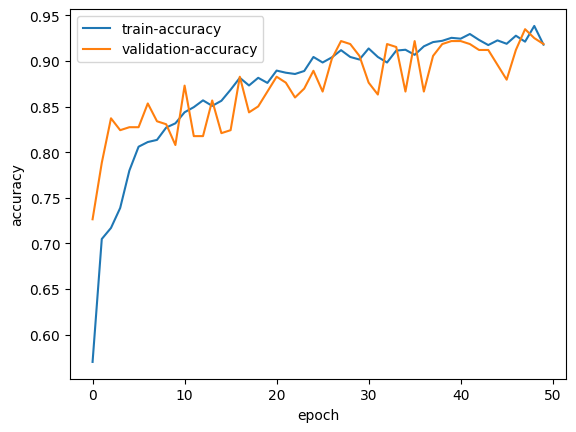

In [23]:
epochs = list(range(len(history.history['accuracy'])))
train_acc = history.history['accuracy']
train_loss = history.history['val_accuracy']
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train-accuracy','validation-accuracy'], loc='best')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

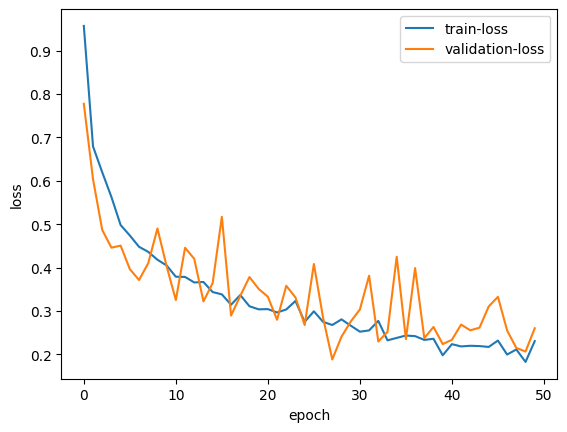

In [24]:
epochs = list(range(len(history.history['accuracy'])))
train_acc = history.history['loss']
train_loss = history.history['val_loss']
plt.plot(train_acc)
plt.plot(train_loss)
plt.legend(['train-loss','validation-loss'], loc='best')
# plt.show()
plt.xlabel('epoch')
plt.ylabel('loss')

# Results 

In [25]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
proba=model.predict(test_images)
predicted = np.argmax(proba,axis=1)
true=test_images.labels
print("acc: ", accuracy_score(predicted, true))
print("preci: ", precision_score(predicted, true,average='macro'))
print("recall: ", recall_score(predicted, true,average='macro'))
print("f1: ", f1_score(predicted, true,average='macro'))
print("mcc: ", matthews_corrcoef(predicted, true))

39/39 [==============================] - 24s 545ms/step
acc:  0.9216965742251223
preci:  0.9139854852003628
recall:  0.9141317399345569
f1:  0.9120757452206215
mcc:  0.878806678345562


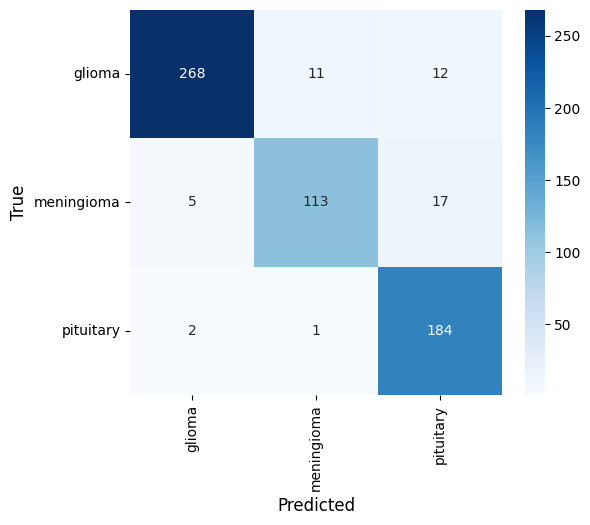

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_=test_images.class_indices.keys()
cm = confusion_matrix(true, predicted)
fig = plt.figure(figsize=(6, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="Blues",  fmt='g'); 
ax.set_xlabel('Predicted', fontsize=12)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=12)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()

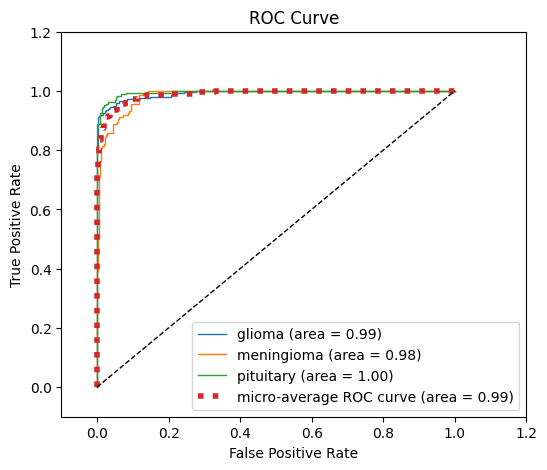

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import cm
n=len(true)
dim=max(true)+1
result=[]
for i in true:
    result.append([0 for i in range(dim)])
    result[len(result)-1][i]=1
    
    
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes =len(test_images.class_indices.keys())
y_test=np.array(result)
y_pred=np.array(proba)
fpr = dict()
tpr = dict()
roc_auc = dict()

rev={}
for i in class_:
    rev[train_images.class_indices[i]]=i


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')


cmap = cm.get_cmap('tab10')

# Plot the ROC curve for each class and micro-average with automatic color selection
plt.figure(figsize=(6,5))
lw = 1
for i in range(n_classes):
    color = cmap(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(rev[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color=cmap(n_classes), linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()